In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import PIL
from IPython.display import Image, display
from PIL import ImageOps
import random
import re

In [2]:
def bgr_to_rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

In [3]:
def get_label(file: str, labels: dict):
    match = re.search('[a-z]+', file).group(0)
    return labels[match]

In [4]:
def load_all_imgs(path, img_size, mode):
    imgs = []
    files = os.listdir(path)
    files.sort()
    print(f'\n{path} found {len(files)} img to load')
    for index, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, mode)
        
        if mode == 0:
            img = np.expand_dims(img, 2)
        
        if mode == 1:
            img = bgr_to_rgb(img)
        img = cv2.resize(img, img_size)
        img = img / 255.
        imgs.append(img)
        if index % 100 == 0:
            print(f'\n[{index}]:', end='')
        else:
            print("|", end='')
    return np.array(imgs)

In [5]:
img_size = (128, 128)
input_dir = "../dataset/segmentation/all_seg/"
target_dir = "../dataset/segmentation/annotation/all/"
num_classes = 1
batch_size = 10
epochs = 100

In [7]:
# Load images
trainImgs = load_all_imgs(input_dir,img_size, 1)
validImgs = load_all_imgs(target_dir,img_size, 0)


../dataset/all_seg/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||
../dataset/annotation/all/ found 120 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||

In [8]:
img_to_test = int(len(trainImgs) * 0.8)
x_train = trainImgs[0:img_to_test]
y_train = validImgs[0:img_to_test]
x_val = trainImgs[img_to_test:]
y_val = validImgs[img_to_test:]
validation_data = (x_val, y_val)
print("ImgToTest:",img_to_test)
print("Validation_data_size:", len(validation_data[0]))

ImgToTest: 96
Validation_data_size: 24


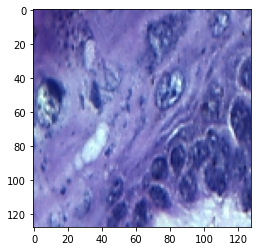

In [9]:
plt.imshow(trainImgs[0])

In [10]:
def unet_v2_get_model(img_size, num_classes, activation="softmax", filters=None):
    down_sampling_filters = [64, 128, 256]
    if filters is not None:
        down_sampling_filters = filters

    up_sampling_filters = down_sampling_filters.copy()
    up_sampling_filters.reverse()
    up_sampling_filters = up_sampling_filters + [32]

    inputs = keras.Input(shape=img_size + (3,))

    # [First half of the network: downsampling inputs]

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    print("down_sampling_filters:", down_sampling_filters)
    for filters in down_sampling_filters:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same", name=f"max_pool_{filters}")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # [Second half of the network: upsampling inputs]

    print("up_sampling_filters:", up_sampling_filters)
    for filters in up_sampling_filters:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation=activation, padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [11]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [12]:
threshold = 0.5
metric = keras.metrics.MeanIoU(num_classes=2)
def mean_iou_threshold(y_true, y_pred):
    y_pred = y_pred.numpy()
    y_pred[y_pred > threshold]= 1
    y_pred[y_pred <= threshold] = 0
    metric.reset_states()
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

2021-10-08 17:29:37.519994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 17:29:37.523083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 17:29:37.523287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 17:29:37.524025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
# Build model
f = [64, 128, 256]
model =  unet_v2_get_model(img_size, 1, 'sigmoid', filters=f)
model.compile(run_eagerly=True,optimizer="adam", loss="binary_crossentropy", metrics=mean_iou_threshold)
model.summary()

down_sampling_filters: [64, 128, 256]
up_sampling_filters: [256, 128, 64, 32]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
________________

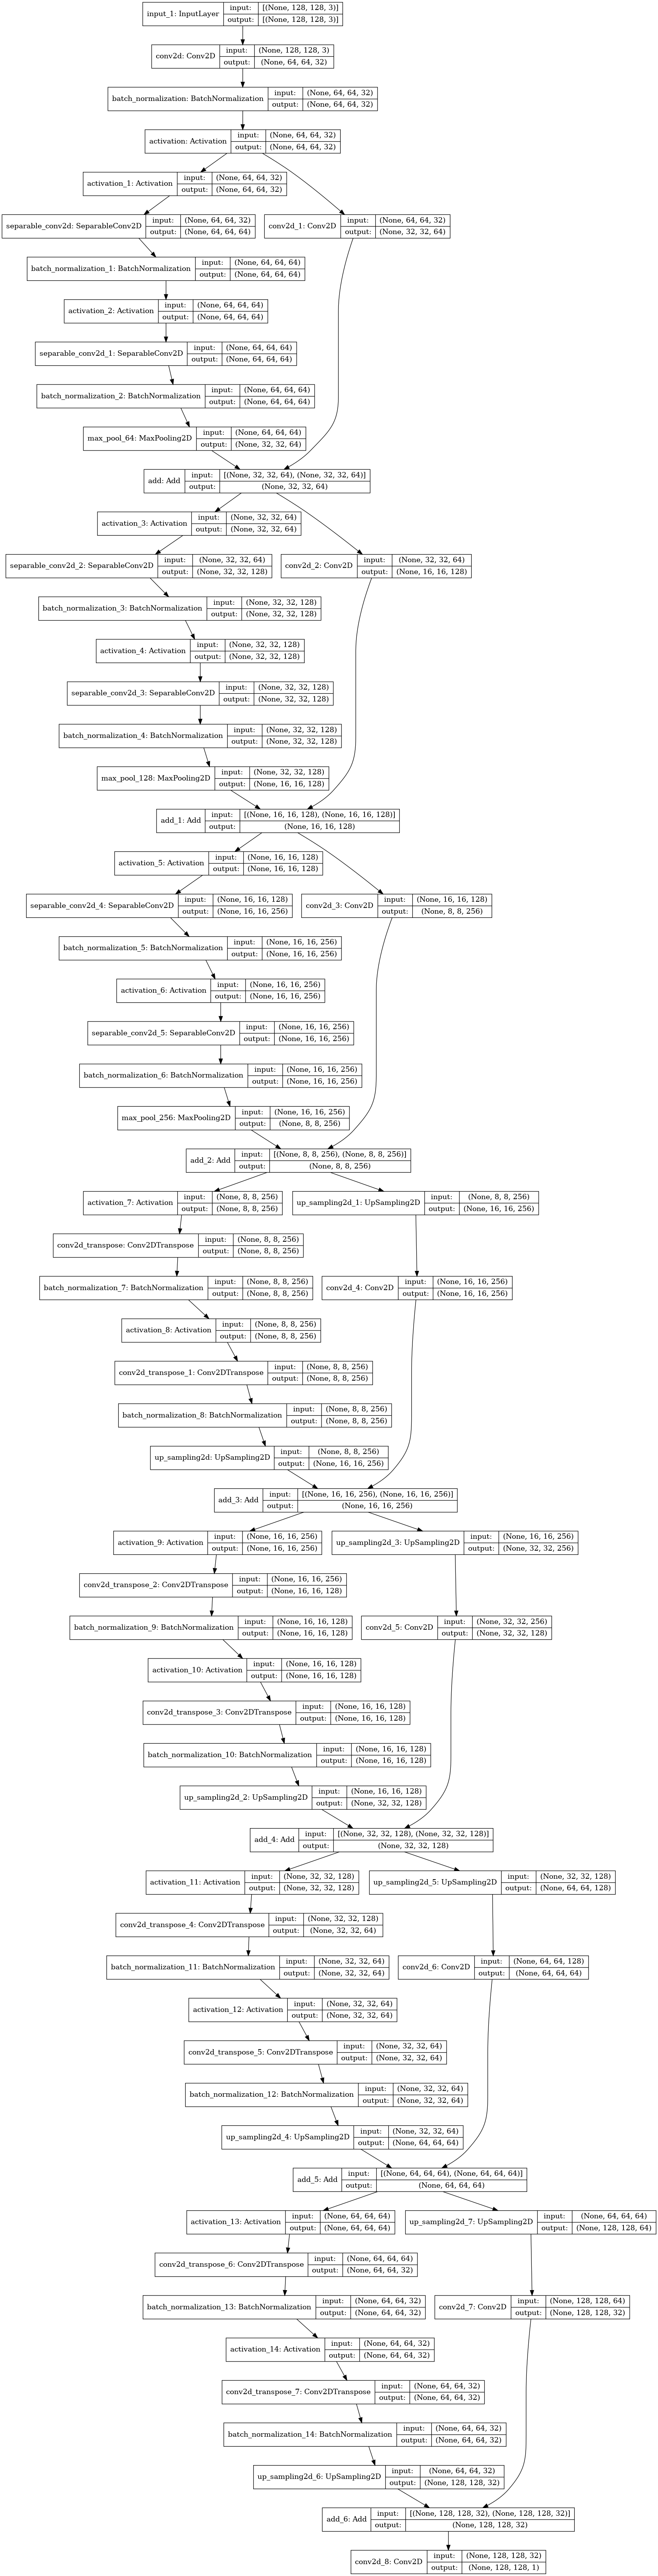

In [14]:
import tensorflow as tf

tf.keras.utils.plot_model(model, to_file="model_unet_v1.png", show_shapes=True)

In [15]:
pred = model.predict(x_train)

2021-10-08 17:29:46.171234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2021-10-08 17:29:46.199730: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2021-10-08 17:29:46.209493: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-08 17:29:46.517231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


In [16]:
pred.shape

(96, 128, 128, 1)

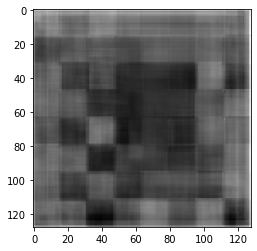

In [17]:
plt.imshow(pred[80], cmap='gray')

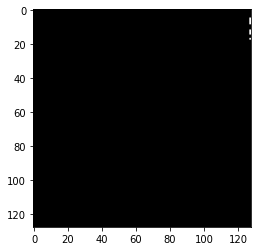

In [18]:
from matplotlib.colors import NoNorm
predict_img = pred[80]
predict_img[predict_img > 0.5] = 1
predict_img[predict_img <= 0.5] = 0

plt.imshow(predict_img, cmap='gray', norm=NoNorm())

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs, validation_data=validation_data, callbacks=callbacks)

2021-10-08 17:29:58.139308: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.


Epoch 1/100
10/10 [==============================] - 3s 189ms/step - loss: 4.1690 - mean_iou_threshold: 0.4035 - val_loss: 3.8233 - val_mean_iou_threshold: 0.3842
Epoch 2/100


/home/neto/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


10/10 [==============================] - 1s 109ms/step - loss: 1.8138 - mean_iou_threshold: 0.4066 - val_loss: 3.7947 - val_mean_iou_threshold: 0.3841
Epoch 3/100
10/10 [==============================] - 1s 104ms/step - loss: 0.7266 - mean_iou_threshold: 0.4443 - val_loss: 1.6399 - val_mean_iou_threshold: 0.3840
Epoch 4/100
10/10 [==============================] - 1s 104ms/step - loss: 0.5984 - mean_iou_threshold: 0.4764 - val_loss: 1.0514 - val_mean_iou_threshold: 0.3840
Epoch 5/100
10/10 [==============================] - 1s 104ms/step - loss: 0.5605 - mean_iou_threshold: 0.4988 - val_loss: 0.9033 - val_mean_iou_threshold: 0.3843
Epoch 6/100
10/10 [==============================] - 1s 104ms/step - loss: 0.5348 - mean_iou_threshold: 0.5164 - val_loss: 0.7180 - val_mean_iou_threshold: 0.3847
Epoch 7/100
10/10 [==============================] - 1s 111ms/step - loss: 0.5249 - mean_iou_threshold: 0.5212 - val_loss: 0.7785 - val_mean_iou_threshold: 0.3839
Epoch 8/100
10/10 [===============

10/10 [==============================] - 1s 115ms/step - loss: 0.1431 - mean_iou_threshold: 0.8490 - val_loss: 0.6695 - val_mean_iou_threshold: 0.4950
Epoch 53/100
10/10 [==============================] - 1s 115ms/step - loss: 0.1482 - mean_iou_threshold: 0.8466 - val_loss: 0.6553 - val_mean_iou_threshold: 0.5119
Epoch 54/100
10/10 [==============================] - 1s 115ms/step - loss: 0.1558 - mean_iou_threshold: 0.8352 - val_loss: 0.6407 - val_mean_iou_threshold: 0.5162
Epoch 55/100
10/10 [==============================] - 1s 113ms/step - loss: 0.1489 - mean_iou_threshold: 0.8422 - val_loss: 0.6335 - val_mean_iou_threshold: 0.5207
Epoch 56/100
10/10 [==============================] - 1s 115ms/step - loss: 0.1412 - mean_iou_threshold: 0.8458 - val_loss: 0.6392 - val_mean_iou_threshold: 0.5199
Epoch 57/100
10/10 [==============================] - 1s 114ms/step - loss: 0.1379 - mean_iou_threshold: 0.8508 - val_loss: 0.6534 - val_mean_iou_threshold: 0.5271
Epoch 58/100
10/10 [=========

In [129]:
def plot_result(img_pred, original, valid):
    plt.figure(figsize=(10, 10))
    n = 1
    for index, img in enumerate(img_pred):
        for i in range(3):
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.subplot(img_pred.shape[0] , 3, n)
            if i == 0:
                original_img = cv2.resize(original[index], img_size)
                plt.imshow(original_img)
                plt.xlabel("Original ")
            if i == 1:
                result_img = cv2.resize(img, img_size)
                plt.imshow(result_img, cmap=plt.cm.binary)
                plt.xlabel("Result", )
            if i == 2:
                valid_img = cv2.resize(valid[index], img_size)
                plt.imshow(valid_img, cmap=plt.cm.binary)
                plt.xlabel("Expected")
            n += 1


../dataset/segmentation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||
../dataset/segmentation/annotation/healthy/ found 30 img to load

[0]:|||||||||||||||||||||||||||||

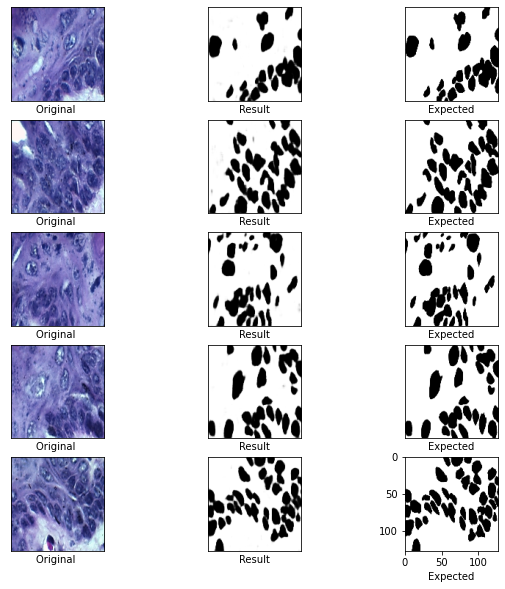

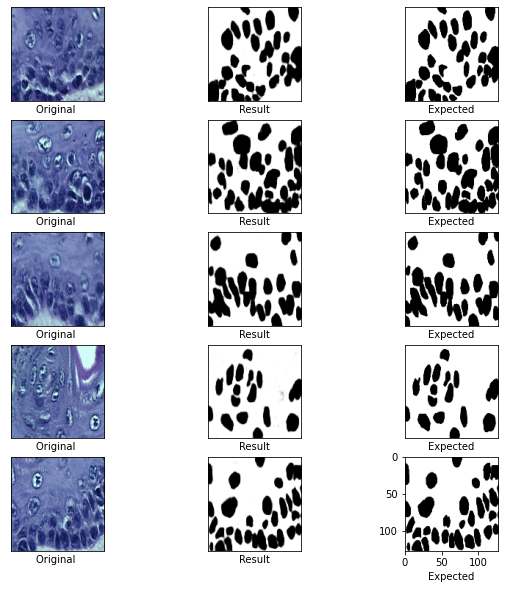

In [134]:
path_healthy_img = '../dataset/segmentation/healthy/'
path_healthy_val = '../dataset/segmentation/annotation/healthy/'

healthy_img = load_all_imgs(path_healthy_img, img_size, 1)
healthy_val = load_all_imgs(path_healthy_val, img_size, 0)
healthy_pred = model.predict(healthy_img)
# ----- Primeiras 5 Imagens -----
plot_result(healthy_pred[:5], healthy_img[:5], healthy_val[:5])
# ----- Ultimas 5 Imagens -----
plot_result(healthy_pred[-5:], healthy_img[-5:], healthy_val[-5:])

In [111]:
pred_imgs = trainImgs[-10:]
pred_valid = validImgs[-10:]

In [65]:
val_preds = model.predict(pred_imgs)

In [66]:
val_preds.shape

(10, 128, 128, 1)

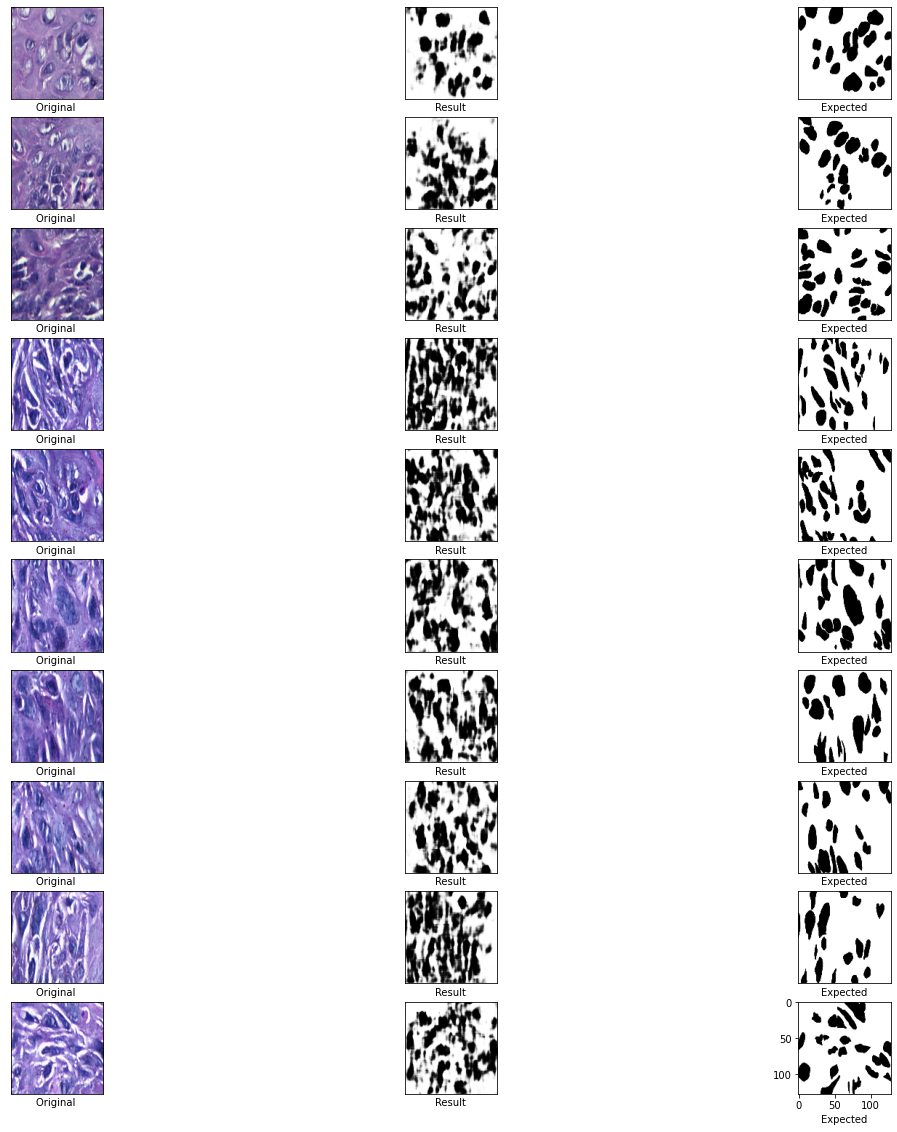

In [71]:
plot_result(val_preds, pred_imgs, pred_valid)

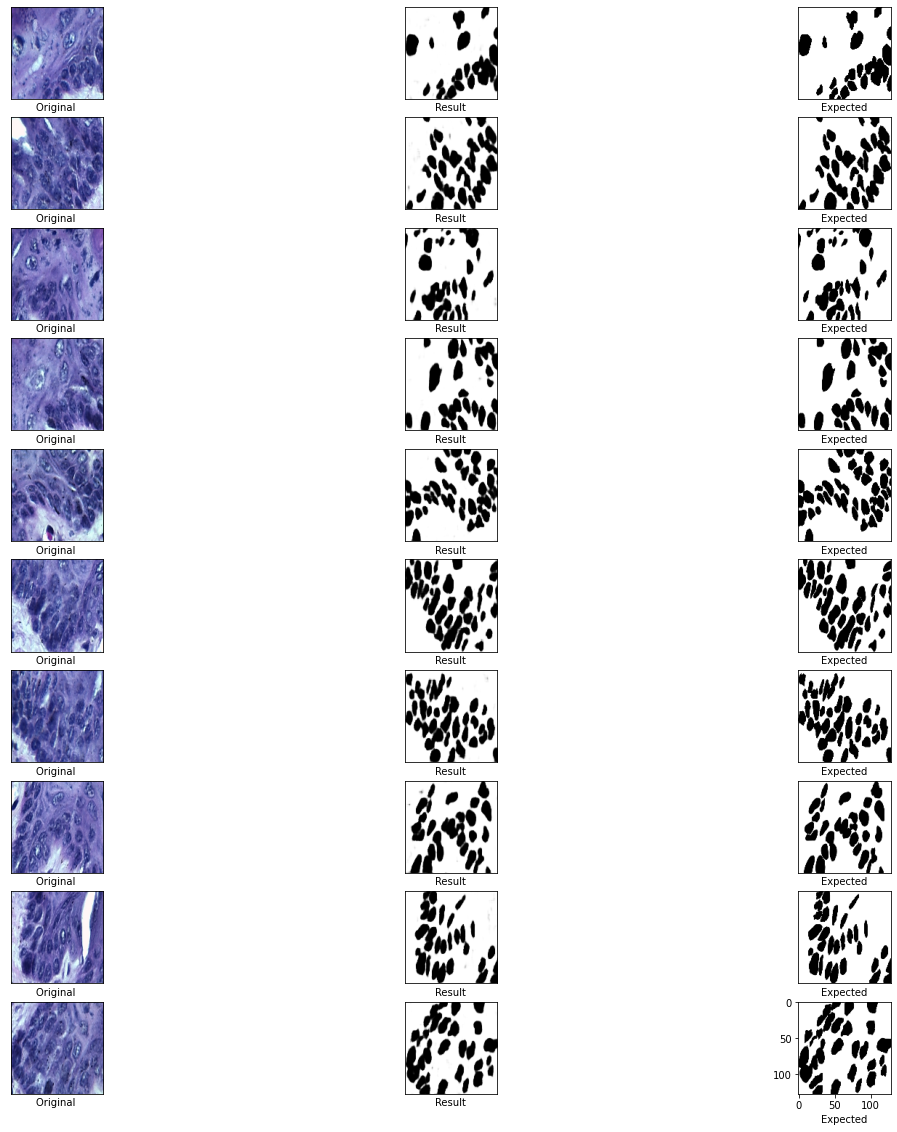

In [72]:
pred_imgs = trainImgs[:10]
pred_valid = validImgs[:10]
val_preds = model.predict(pred_imgs)
plot_result(val_preds, pred_imgs, pred_valid)

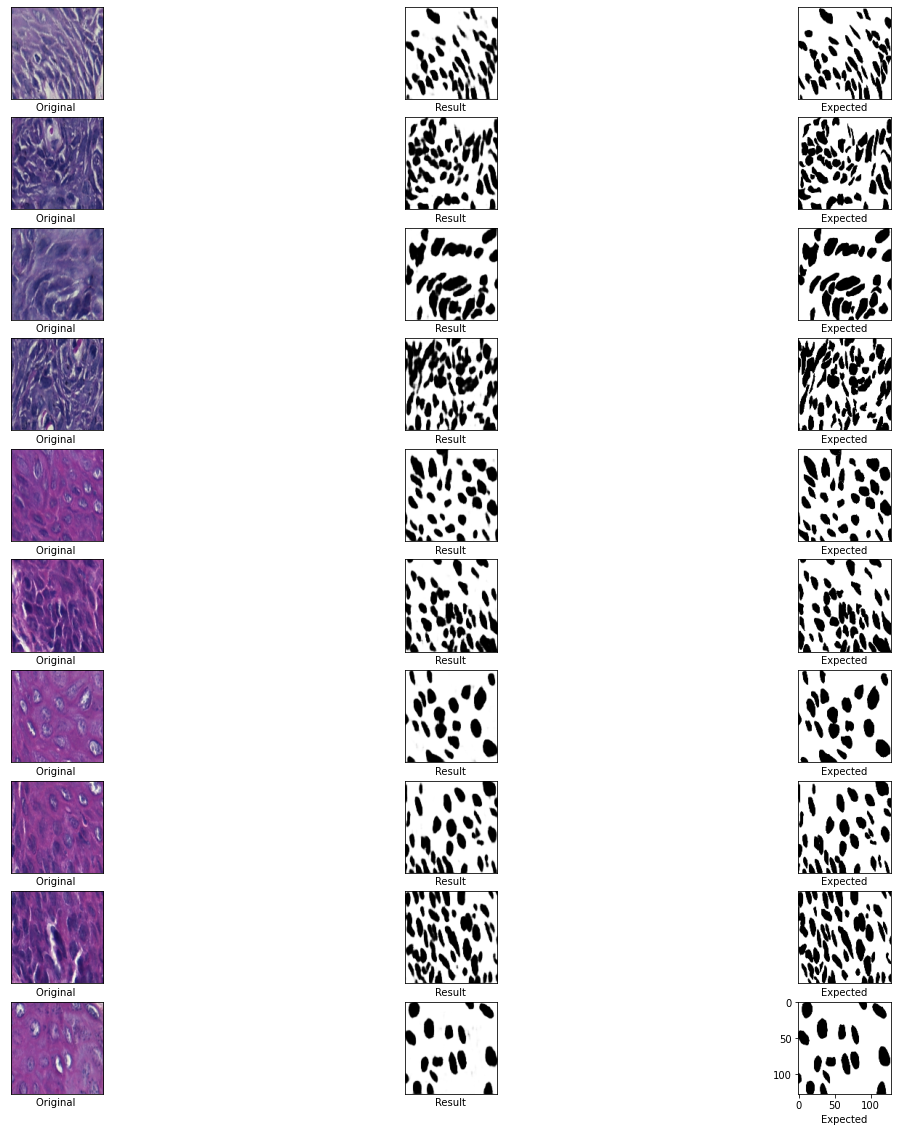

In [73]:
pred_imgs = trainImgs[30:40]
pred_valid = validImgs[30:40]
val_preds = model.predict(pred_imgs)
plot_result(val_preds, pred_imgs, pred_valid)

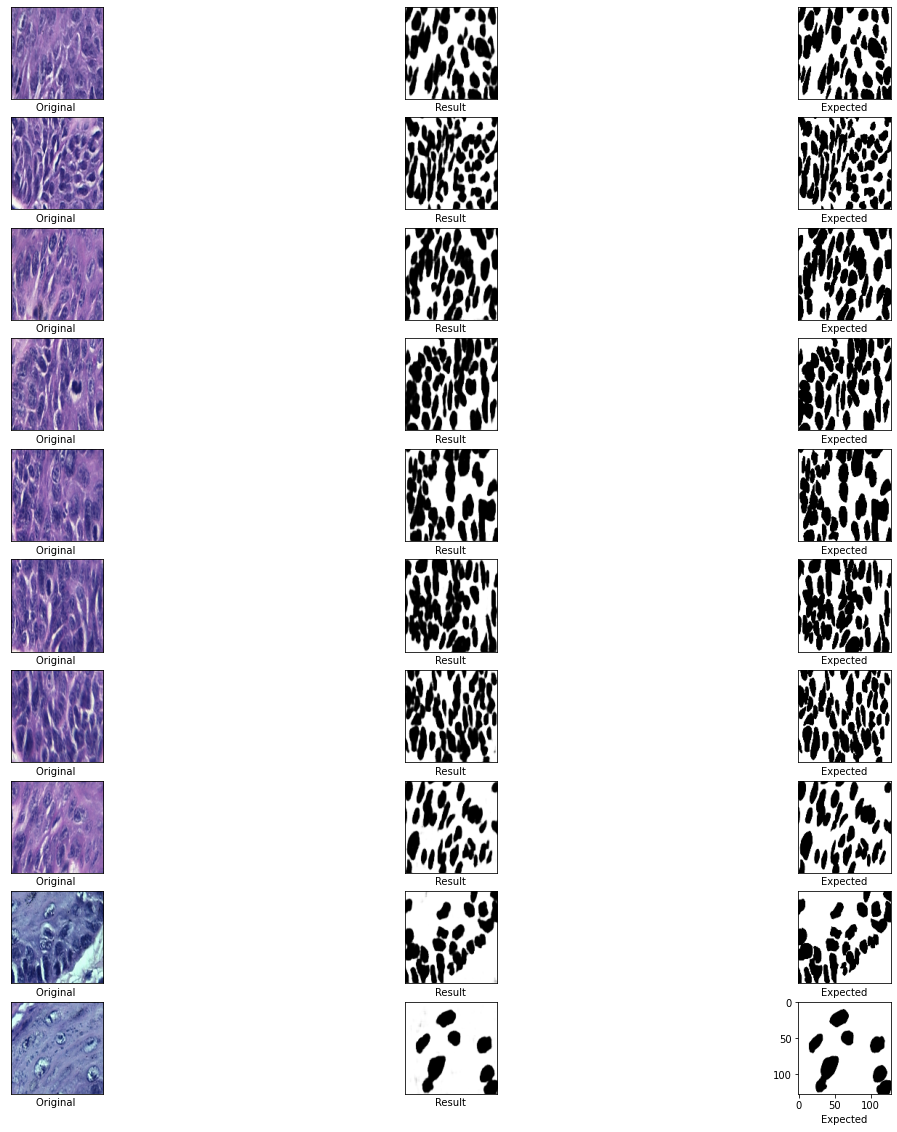

In [74]:
pred_imgs = trainImgs[61:71]
pred_valid = validImgs[61:71]
val_preds = model.predict(pred_imgs)
plot_result(val_preds, pred_imgs, pred_valid)